# Business Understanding

Cohort analysis is a type of behavioral analytics in which you take a group of users, and analyze their usage patterns based on their shared traits to better track and understand their actions. A cohort is simply a group of people with shared characteristics.

Customer retention rate is a metric that measures the percentage of customers who continue to make transactions in a certain period. This metric is very important because it can show a retail company's capabilities and processes in maintaining customer loyalty, which is very important for long-term growth and revenue.

$\text{Customer retention rate (%)} = (\frac{E - N}{S}) x 100$

with:
- E = number of customers at the end of the period
- N = number of customers added within the time period
- S = number of customers at the start of a given period

Monthly retention rates provide detailed information into customer behavior and engagement, providing companies learn about transactions patterns, evaluate the efficiency of campaigns, and perform timely interventions that increase customer loyalty and reduce churn rates.

In this project, descriptive statistics will be used for analysis. Monthly retention will be calculated using the customer retention rate formula, with the specified period being monthly.

# Data Understanding

The dataset in this project is [Retail Store Sales Transactions (Scanner Data)](https://www.kaggle.com/datasets/marian447/retail-store-sales-transactions) taken from the Kaggle dataset repository.

The anonymized dataset includes 64,682 transactions of 5,242 SKU's sold to 22,625 customers during one year (2016).

Columns in the dataset include:
- `Date` = date of sales transaction
- `Customer_ID` = customer ID
- `Transaction_ID` = transaction ID
- `SKU_Category` = SKU Category ID
- `SKU` = SKU ID
- `Quantity` = quantity of item sold
- `Sales_Amount` = sales amount (unit price times quantity)

# Data Collection

In [ ]:
# Import and unzip dataset
from zipfile import ZipFile
dataset =  "Retail Store Sales Transactions (Scanner Data).zip"

with ZipFile(dataset, 'r') as zip:
  zip.printdir()
  zip.extractall()
  print('Done')

File Name                                             Modified             Size
scanner_data.csv                               2021-05-19 09:08:42      6161549
Done


In [ ]:
# Load dataset
import pandas as pd
data = pd.read_csv('scanner_data.csv')
data.head()

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,3,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,4,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,5,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


In [ ]:
# Dataset info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      131706 non-null  int64  
 1   Date            131706 non-null  object 
 2   Customer_ID     131706 non-null  int64  
 3   Transaction_ID  131706 non-null  int64  
 4   SKU_Category    131706 non-null  object 
 5   SKU             131706 non-null  object 
 6   Quantity        131706 non-null  float64
 7   Sales_Amount    131706 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 8.0+ MB


In [ ]:
# Summarize the dataset
data.describe()

,Unnamed: 0,Customer_ID,Transaction_ID,Quantity,Sales_Amount
count,131706.000000,131706.000000,131706.000000,131706.000000,131706.000000
mean,65853.500000,12386.450367,32389.604187,1.485311,11.981524
std,38020.391614,6086.447552,18709.901238,3.872667,19.359699
min,1.000000,1.000000,1.000000,0.010000,0.020000
25%,32927.250000,7349.000000,16134.000000,1.000000,4.230000
50%,65853.500000,13496.000000,32620.000000,1.000000,6.920000
75%,98779.750000,17306.000000,48548.000000,1.000000,12.330000
max,131706.000000,22625.000000,64682.000000,400.000000,707.730000


All quantity and sales amount show positive value.

In [ ]:
data.describe(include='O')

,Date,SKU_Category,SKU
count,131706,131706,131706
unique,363,187,5242
top,23/09/2016,N8U,UNJKW
freq,638,10913,2007


In [ ]:
# Check the missing values
data.isnull().sum()

Unnamed: 0        0
Date              0
Customer_ID       0
Transaction_ID    0
SKU_Category      0
SKU               0
Quantity          0
Sales_Amount      0
dtype: int64

No missing value in data

# Data Preparation

## Data Cleaning

In [ ]:
# Create dataset copy
df = data.copy()

# Delete unnecessary columns
del df['Unnamed: 0']

# Change column names to lower case
df.columns = df.columns.str.lower()

# Convert 'date' column datatype to datetime
import datetime as dt
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')
df['date'] = df['date'].astype('datetime64[ns]')
# Create column 'year_month'
df['year_month'] = df['date'].dt.to_period('M')

In [ ]:
# Replace the sku of a 'sku_category' that has several 'sku' with one of the 'sku' that appears most frequently
most_freq_sku = df.groupby(['sku', 'sku_category'], as_index=False).agg(order_cnt=('transaction_id', 'nunique')).sort_values(['sku_category','order_cnt'], ascending=[True, False])
most_freq_sku['rank'] = most_freq_sku.groupby('sku_category')['order_cnt'].rank(method='first', ascending=False)
most_freq_sku = most_freq_sku[most_freq_sku['rank'] == 1].drop(columns=['rank', 'order_cnt'])
df = df.merge(most_freq_sku.rename(columns={'sku': 'most_freq_sku'}), how='left', on='sku_category')
df['sku'] = df['most_freq_sku']
df = df.drop('most_freq_sku', axis=1)

In [ ]:
# Convert 'customer_id' datatype as string
df['customer_id'] = df['customer_id'].astype(str)

# Delete outliers
from scipy import stats
df = df[((stats.zscore(df[['quantity', 'sales_amount']])) < 3).all(axis=1)]
df = df.reset_index(drop=True)

df

,date,customer_id,transaction_id,sku_category,sku,quantity,sales_amount,year_month
0,2016-01-02,2547,1,X52,GZN4P,1.0,3.13,2016-01
1,2016-01-02,822,2,2ML,3SZO0,1.0,5.46,2016-01
2,2016-01-02,3686,3,0H2,CZUZX,1.0,6.35,2016-01
3,2016-01-02,3719,4,0H2,CZUZX,1.0,5.59,2016-01
4,2016-01-02,9200,5,0H2,CZUZX,1.0,6.88,2016-01
...,...,...,...,...,...,...,...,...
129408,2016-07-04,20203,32900,IEV,4FT32,3.0,6.46,2016-07
129409,2016-07-04,20203,32900,N8U,UNJKW,1.0,4.50,2016-07
129410,2016-07-04,20203,32900,U5F,4X8P4,1.0,5.19,2016-07
129411,2016-07-04,20203,32900,0H2,CZUZX,1.0,4.57,2016-07


In [ ]:
# Get df dataframe specified information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129413 entries, 0 to 129412
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            129413 non-null  datetime64[ns]
 1   customer_id     129413 non-null  object        
 2   transaction_id  129413 non-null  int64         
 3   sku_category    129413 non-null  object        
 4   sku             129413 non-null  object        
 5   quantity        129413 non-null  float64       
 6   sales_amount    129413 non-null  float64       
 7   year_month      129413 non-null  period[M]     
dtypes: datetime64[ns](1), float64(2), int64(1), object(3), period[M](1)
memory usage: 7.9+ MB


## Data Aggregation

In [ ]:
# # Group the data by 'customer_id' and 'year_month' & count the unique transactions per customer per month
df_customer_monthly = df.groupby(['customer_id', 'year_month'], as_index=False).agg(order_cnt=('transaction_id', 'nunique'))
df_customer_monthly.head()

,customer_id,year_month,order_cnt
0,1,2016-01,1
1,100,2016-01,1
2,1000,2016-02,1
3,10000,2016-05,2
4,10001,2016-05,1


In [ ]:
# Create 'cohort' column
df_customer_monthly['cohort'] = df_customer_monthly.groupby('customer_id')['year_month'].transform('min')
df_customer_monthly.head()

,customer_id,year_month,order_cnt,cohort
0,1,2016-01,1,2016-01
1,100,2016-01,1,2016-01
2,1000,2016-02,1,2016-02
3,10000,2016-05,2,2016-05
4,10001,2016-05,1,2016-05


In [ ]:
# Calculate the number gap of customer's first transaction and last transaction (in month)
from operator import attrgetter
df_customer_monthly['period_num'] = (df_customer_monthly['year_month'] - df_customer_monthly['cohort']).apply(attrgetter('n')) + 1
df_customer_monthly.head()

,customer_id,year_month,order_cnt,cohort,period_num
0,1,2016-01,1,2016-01,1
1,100,2016-01,1,2016-01,1
2,1000,2016-02,1,2016-02,1
3,10000,2016-05,2,2016-05,1
4,10001,2016-05,1,2016-05,1


## Create Cohort Table

In [ ]:
df_cohort_pivot = pd.pivot_table(df_customer_monthly, index='cohort', columns='period_num', values='customer_id', aggfunc=pd.Series.nunique)
df_cohort_pivot

period_num,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,
2016-01,3385.0,1297.0,1015.0,592.0,264.0,194.0,152.0,136.0,90.0,54.0,41.0,40.0
2016-02,2209.0,474.0,288.0,146.0,95.0,68.0,68.0,57.0,21.0,18.0,14.0,NaN
2016-03,2626.0,742.0,641.0,596.0,527.0,516.0,527.0,509.0,507.0,530.0,NaN,NaN
2016-04,2506.0,724.0,631.0,543.0,562.0,589.0,554.0,562.0,574.0,NaN,NaN,NaN
2016-05,2611.0,621.0,553.0,501.0,563.0,547.0,523.0,521.0,NaN,NaN,NaN,NaN
2016-06,1568.0,275.0,272.0,278.0,278.0,274.0,299.0,NaN,NaN,NaN,NaN,NaN
2016-07,1212.0,170.0,186.0,187.0,181.0,199.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-08,1050.0,161.0,138.0,141.0,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09,1611.0,304.0,255.0,289.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Calculate the number of customer
cohort_size = df_cohort_pivot.iloc[:,0]
cohort_size

cohort
2016-01    3385.0
2016-02    2209.0
2016-03    2626.0
2016-04    2506.0
2016-05    2611.0
2016-06    1568.0
2016-07    1212.0
2016-08    1050.0
2016-09    1611.0
2016-10    1354.0
2016-11    1187.0
2016-12    1199.0
Freq: M, Name: 1, dtype: float64

In [ ]:
# Create retention rate dataframe (in percentage)
df_retention_cohort = df_cohort_pivot.divide(cohort_size, axis=0)
df_retention_cohort

period_num,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,
2016-01,1.0,0.383161,0.299852,0.174889,0.077991,0.057312,0.044904,0.040177,0.026588,0.015953,0.012112,0.011817
2016-02,1.0,0.214577,0.130376,0.066093,0.043006,0.030783,0.030783,0.025804,0.009507,0.008148,0.006338,NaN
2016-03,1.0,0.282559,0.244097,0.226961,0.200685,0.196497,0.200685,0.193831,0.193069,0.201828,NaN,NaN
2016-04,1.0,0.288907,0.251796,0.216680,0.224262,0.235036,0.221069,0.224262,0.229050,NaN,NaN,NaN
2016-05,1.0,0.237840,0.211796,0.191881,0.215626,0.209498,0.200306,0.199540,NaN,NaN,NaN,NaN
2016-06,1.0,0.175383,0.173469,0.177296,0.177296,0.174745,0.190689,NaN,NaN,NaN,NaN,NaN
2016-07,1.0,0.140264,0.153465,0.154290,0.149340,0.164191,NaN,NaN,NaN,NaN,NaN,NaN
2016-08,1.0,0.153333,0.131429,0.134286,0.120000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09,1.0,0.188703,0.158287,0.179392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Visualization

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
%matplotlib inline

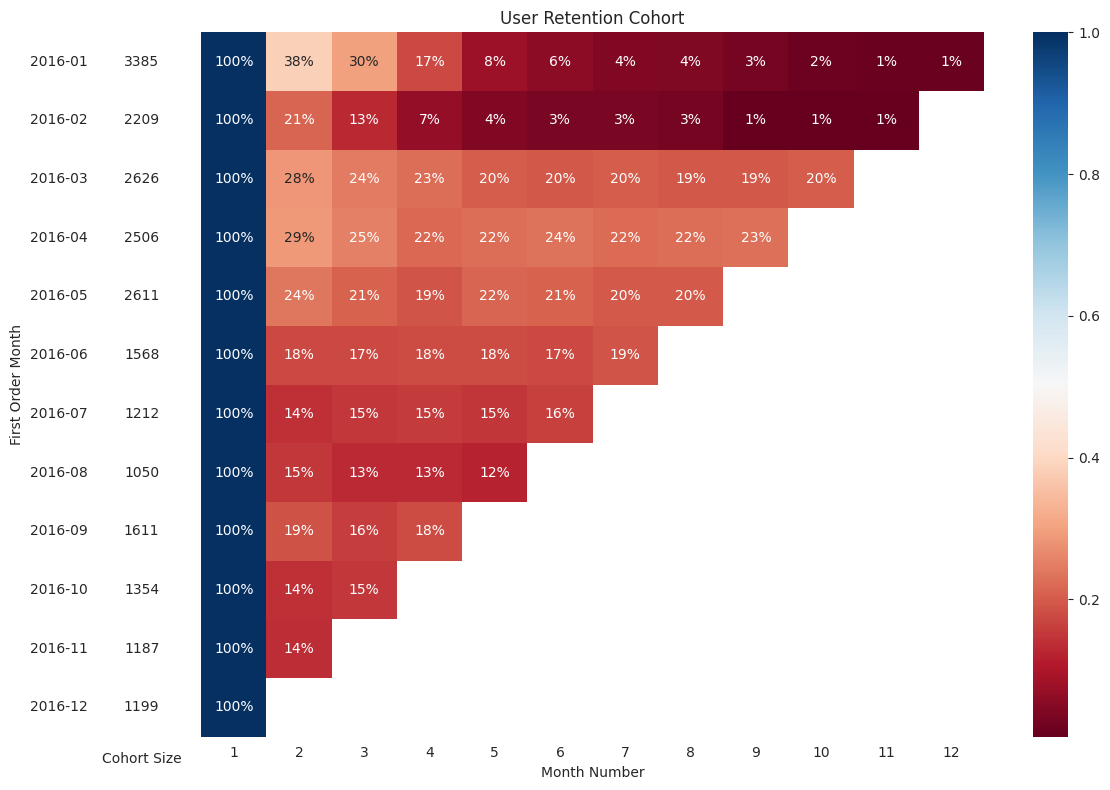

In [ ]:
# Create retention rate chart
with sns.axes_style('white'):

  fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios':[1, 11]})

  # Cohort chart
  df_cohort_size = pd.DataFrame(cohort_size)
  white_cmap = mcolors.ListedColormap('White')
  sns.heatmap(df_cohort_size, cbar=False, annot=True, fmt='g', cmap=white_cmap, ax=ax[0])
  ax[0].tick_params(bottom=False)
  ax[0].set(xlabel='Cohort Size', ylabel='First Order Month', xticklabels=[])

  # User retention cohort
  sns.heatmap(df_retention_cohort, annot=True, fmt='.0%', cmap='RdBu', ax=ax[1])
  ax[1].set_title('User Retention Cohort')
  ax[1].set(xlabel='Month Number', ylabel='')

  fig.tight_layout()

# Insights

* The **January** cohort had a retention rate of 38% the following month. A big decline but the best compared to other cohorts.
* Several cohorts showed significant declines. For example, the **September** cohort fell from 100% to 19% the following month.
* The **April** cohort showed a stable retention rate in the range of 22% - 24% starting in the third month onwards.
* The **April** and **March** cohorts showed a high and stable retention rate compared to other months. Meanwhile, the **January** and **February** cohorts were the weakest with several subsequent month retention rates reaching 1%.

* The **spring season** cohort (**March** - **May**) showed a relatively high and stable retention rate compared to other seasons.

# Recommendations


*   Perform an in-depth analysis of the **March** and **April** cohorts and find out what factors contribute to their higher retention rates. The reason of the significant drop in retention rates in the **January** and **March** cohorts also must be studied.

* Gain multiple insights by using other analysis methods such as A/B testing, customer segmentation, product recommendation, etc. Track customer behavior with CRM software.

* Collect feedback from customers to identify variables for improvement by improving customer support and online community.

*    Apply exclusive marketing and promotions in the **spring seasons (March to May)** for covering the regular seasonal drop in customer retention. Provide exclusive offers, discounts, and rewards to keep customers around during specific periods of time.

*   Improve loyalty programs that reward users for continued loyalty and repeat transactions, especially for new customers in the **winter seasons (December to January)**.



# References

* [A beginner's guide to cohort analysis: How to reduce churn and make better product decisions](https://www.appcues.com/blog/cohort-analysis)
* [Customer retention rate + formula: A guide for 2024](https://www.zendesk.com/blog/calculate-customer-retention-rate/)
* [How to Boost Customer Retention](https://www.business.com/articles/boost-customer-retention/)
